<a href="https://colab.research.google.com/github/vchandraiitk/datascience/blob/main/Vikas_M6_NB_MiniProject_3_Video_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Advanced Certification Program in Computational Data Science

##  A program by IISc and TalentSprint

### Mini Project Notebook: Video based Action Classification using LSTM

## Learning Objectives

At the end of the experiment, you will be able to :

* extract frames out of a video
* build the CNN model to extract features from the video frames
* train LSTM/GRU model to perform action classification

## Information

**Background:** The CNN LSTM architecture involves using Convolutional Neural Network (CNN) layers for feature extraction on input data combined with LSTMs to support sequence prediction.

CNN LSTMs were developed for visual time series prediction problems and the application of generating textual descriptions from sequences of images (e.g. videos). Specifically, the problems of:



*   Activity Recognition: Generating a textual description of an activity demonstrated in a sequence of images
*   Image Description: Generating a textual description of a single image.
*   Video Description: Generating a textual description of a sequence of images.

**Applications:** Applications such as surveillance, video retrieval and
human-computer interaction require methods for recognizing human actions in various scenarios. In the area of robotics, the tasks of
autonomous navigation or social interaction could also take advantage of the knowledge extracted
from live video recordings. Typical scenarios
include scenes with cluttered, moving backgrounds, nonstationary camera, scale variations, individual variations in
appearance and cloth of people, changes in light and view
point and so forth. All of these conditions introduce challenging problems that can be addressed using deep learning (computer vision) models.

## Dataset



**Dataset:** This dataset consists of labelled videos of 6 human actions (walking, jogging, running, boxing, hand waving and hand clapping) performed several times by 25 subjects in four different scenarios: outdoors s1, outdoors with scale variation s2, outdoors with different clothes s3 and indoors s4 as illustrated below.

![img](https://cdn.iisc.talentsprint.com/CDS/Images/actions.gif)

All sequences were taken over homogeneous backgrounds with a static camera with 25fps frame rate. The sequences were downsampled to the spatial resolution of 160x120 pixels and have a length of four seconds in average. In summary, there are 25x6x4=600 video files for each combination of 25 subjects, 6 actions and 4 scenarios. For this mini-project we have randomly selected 20% of the data as test set.

Dataset source: https://www.csc.kth.se/cvap/actions/

**Methodology:**

When performing image classification, we input an image to our CNN; Obtain the predictions from the CNN;
Choose the label with the largest corresponding probability


Since a video is just a series of image frames, in a video classification, we Loop over all frames in the video file;
For each frame, pass the frame through the CNN; Classify each frame individually and independently of each other; Choose the label with the largest corresponding probability;
Label the frame and write the output frame to disk

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import os
os.chdir('/content/drive/MyDrive/ISC/MiniProject/M6-Mp3')
os.environ['HOME'] = '/content/drive/MyDrive/ISC/MiniProject/M6-Mp3'

Refer this [Video Classification using Keras](https://medium.com/video-classification-using-keras-and-tensorflow/action-recognition-and-video-classification-using-keras-and-tensorflow-56badcbe5f77) for complete understanding and implementation example of video classification.

## Problem Statement

Train a CNN-LSTM based deep neural net to recognize the action being performed in a video

## Grading = 10 Points

### Install and re-start the runtime

In [26]:
!pip3 install imageio==2.4.1

In [27]:
#@title Download Dataset
# !wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/Actions.zip
# !unzip -qq Actions.zip
# print("Dataset downloaded successfully!!")

### Import required packages

In [28]:
import keras
from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import *
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense, Input
#from keras.layers.pooling import GlobalAveragePooling2D
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from keras.layers import GRU, Dense, Dropout
#from keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.optimizers import Adam

import os, glob
import cv2
import numpy as np
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

### Load the data and generate frames of video (2 points)

Detecting an action is possible by analyzing a series of images (that we name “frames”) that are taken in time.

Hint: Refer data preparation section in [keras_video_classification](https://keras.io/examples/vision/video_classification/)


In [29]:
data_dir = "/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/train/"
test_data_dir = "/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/test/"
# YOUR CODE HERE
def parse_video(video_path):
    total_files = 0
    files_count_per_directory = defaultdict(int)
    files_name_per_directory = defaultdict(lambda: '')
    for root, dirs, files in os.walk(video_path):
        #print(dirs)
        for file in files:
            total_files += 1
            files_count_per_directory[os.path.basename(root)] += 1
            files_name_per_directory[os.path.basename(root)] += file + ','
            #print(os.path.join(root, file))
            #print(os.path.basename(root))  # Prints the full path of each file
    print(f'Total Files {total_files}')
    #print(files_count_per_directory)
    #print(files_name_per_directory)
    df = pd.DataFrame(files_count_per_directory.items(), columns=['Action', 'Count'])
    print(df)
print('-------Videos in Training Dataset-------')
parse_video(data_dir)
print('----------------------------------------')
print('-------Videos in Test Dataset-------')
parse_video(test_data_dir)
print('----------------------------------------')

-------Videos in Training Dataset-------
Total Files 479
         Action  Count
0       Walking     80
1       jogging     80
2       running     80
3  Handclapping     79
4    handwaving     80
5        boxing     80
----------------------------------------
-------Videos in Test Dataset-------
Total Files 120
         Action  Count
0        boxing     20
1  Handclapping     20
2    handwaving     20
3       jogging     20
4       running     20
5       Walking     20
----------------------------------------


#### Visualize the frames and analyze the object in each frame. (1 point)

* Plot the frames of each class per row (6 rows)
* Plot the title as label on each subplot

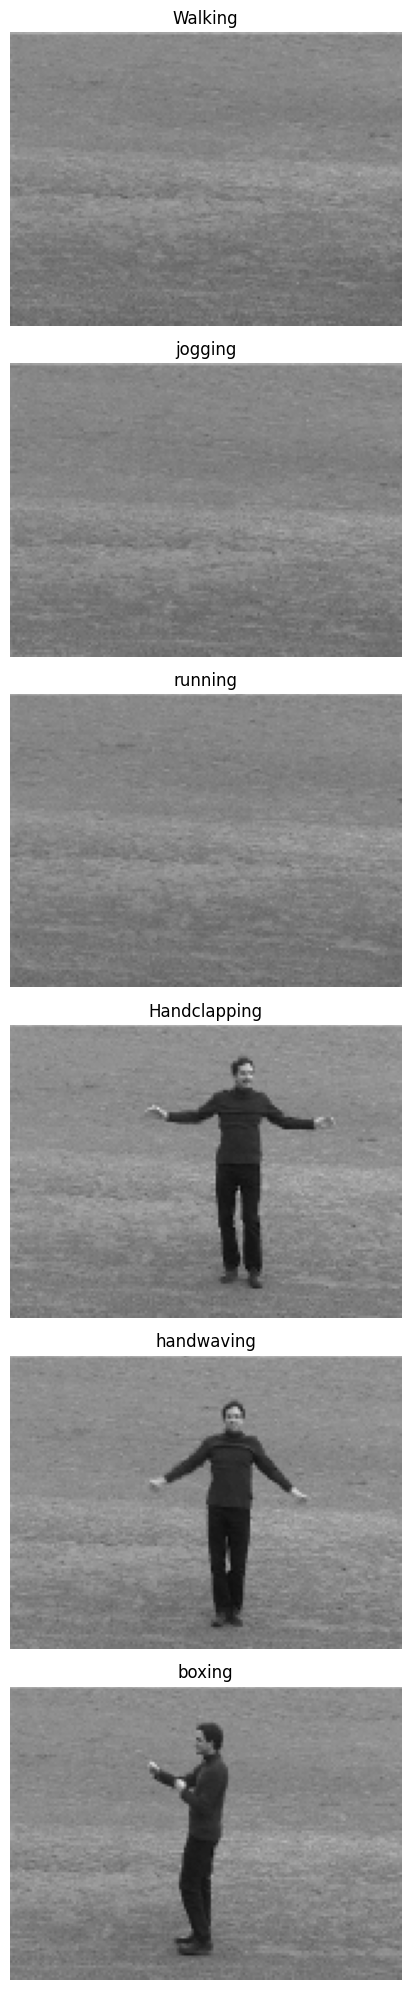

In [30]:
# YOUR CODE HERE
# Get a list of all action classes
action_classes = os.listdir(data_dir)

# Create a figure and subplots
fig, axes = plt.subplots(nrows=len(action_classes), ncols=1, figsize=(10, 20))

# Loop through each action class
for i, action_class in enumerate(action_classes):
    # Get a list of video files for the current action class
    video_files = glob.glob(os.path.join(data_dir, action_class, '*.avi'))

    # Read the first frame of the first video file
    video_path = video_files[0]
    cap = cv2.VideoCapture(video_path)
    ret, frame = cap.read()
    cap.release()

    # Display the frame in the subplot
    if ret:  # Check if frame was read successfully
        axes[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        axes[i].set_title(action_class)
        axes[i].axis('off')  # Turn off axis ticks and labels

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()

### Create the Neural Network (4 points)

We can build the model in several ways. We can use a well-known model that we inject in time distributed layer, or we can build our own.

With custom ConvNet each input image of the sequence must pass to a convolutional network. The goal is to train that model for each frame and then decide the class to infer.

* Use ConvNet and Time distributed to detect features.
* Inject the Time distributed output to GRU or LSTM to treat as a time series.
* Apply a DenseNet to take the decision and classify.

##### Build the ConvNet for the feature extraction, GRU LSTM layers as a time series and Dense layers for classification

In [31]:
# YOUR CODE HERE
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed, GRU, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential

def create_cnn_gru_model(input_shape=(10, 112, 112, 3), num_classes=6):
    """
    Creates a CNN-GRU model for video classification.

    Args:
        input_shape: Shape of the input video frames (timesteps, height, width, channels).
        num_classes: Number of action classes to classify.

    Returns:
        A Keras model instance.
    """
    momentum = 0.9

    # Build the ConvNet for feature extraction
    convnet = Sequential()
    convnet.add(Conv2D(64, (3, 3), input_shape=input_shape[1:], padding='same', activation='relu'))
    convnet.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    convnet.add(BatchNormalization(momentum=momentum))
    convnet.add(MaxPool2D())
    convnet.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    convnet.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    convnet.add(BatchNormalization(momentum=momentum))
    convnet.add(MaxPool2D())
    convnet.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    convnet.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    convnet.add(BatchNormalization(momentum=momentum))
    convnet.add(MaxPool2D())
    convnet.add(GlobalMaxPool2D())  # Flatten features

    # Create the main model
    model = Sequential()
    model.add(TimeDistributed(convnet, input_shape=input_shape))  # Apply ConvNet to each frame
    model.add(GRU(128, return_sequences=False))  # GRU layer for time series handling
    model.add(Dense(num_classes, activation='softmax'))  # Dense layer for classification

    return model

# Example usage:
model = create_cnn_gru_model()
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_3 (TimeDistributed) │ (None, 10, 256)             │       1,147,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_3 (GRU)                          │ (None, 128)                 │         148,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,296,198 (4.94 MB)

 Trainable params: 1,295,302 (4.94 MB)

 Non-trainable params: 896 (3.50 KB)

In [32]:
import os
import glob
import cv2
import numpy as np
from multiprocessing import Pool, cpu_count

data_dir = "/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/train/"
test_data_dir = "/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/test/"
img_height, img_width = 112, 112
seq_len = 20  # Number of frames to extract from each video

def process_video(args):
    video_file, seq_len, img_height, img_width = args
    frames = []
    cap = cv2.VideoCapture(video_file)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Select frames evenly spaced in time
    frame_indices = np.linspace(0, frame_count - 1, seq_len, dtype=int)

    for i in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            frame = cv2.resize(frame, (img_height, img_width))
            frames.append(frame)
    cap.release()

    return np.array(frames) if len(frames) == seq_len else None

def load_and_preprocess_data_multiprocessing(data_directory):
    data = []
    labels = []
    classes = os.listdir(data_directory)
    class_map = {label.lower(): i for i, label in enumerate(classes)}

    video_files_with_classes = []
    for action_class in classes:
        class_dir = os.path.join(data_directory, action_class)
        video_files = glob.glob(os.path.join(class_dir, '*.avi'))
        video_files_with_classes.extend([(video, class_map[action_class.lower()]) for video in video_files])
    print(video_files_with_classes)
    with Pool(processes=cpu_count()) as pool:
        results = pool.map(process_video, [(video, seq_len, img_height, img_width) for video, _ in video_files_with_classes])

    for i, frames in enumerate(results):
        if frames is not None:
            data.append(frames)
            labels.append(video_files_with_classes[i][1])

    return np.array(data), np.array(labels)

# Load and preprocess the training data using multiprocessing
train_data, train_labels = load_and_preprocess_data_multiprocessing(data_dir)

# Load and preprocess the test data using multiprocessing
test_data, test_labels = load_and_preprocess_data_multiprocessing(test_data_dir)


[('/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/train/Walking/person01_walking_d1_uncomp.avi', 0), ('/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/train/Walking/person01_walking_d2_uncomp.avi', 0), ('/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/train/Walking/person01_walking_d3_uncomp.avi', 0), ('/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/train/Walking/person01_walking_d4_uncomp.avi', 0), ('/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/train/Walking/person02_walking_d1_uncomp.avi', 0), ('/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/train/Walking/person02_walking_d2_uncomp.avi', 0), ('/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/train/Walking/person02_walking_d3_uncomp.avi', 0), ('/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/train/Walking/person02_walking_d4_uncomp.avi', 0), ('/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/train/Walking/person03_walking_d1_uncomp.avi', 0), ('/content/drive/MyDrive/ISC/MiniPro

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

Epoch 1/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.1910 - loss: 2.0763 - val_accuracy: 0.0500 - val_loss: 2.3991
Epoch 2/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.3094 - loss: 1.4739 - val_accuracy: 0.0583 - val_loss: 3.0310
Epoch 3/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.3317 - loss: 1.3663 - val_accuracy: 0.0000e+00 - val_loss: 3.5967
Epoch 4/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.4341 - loss: 1.1700 - val_accuracy: 0.0167 - val_loss: 4.3860
Epoch 5/5
15/15 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step - accuracy: 0.4076 - loss: 1.1211 - val_accuracy: 0.0083 - val_loss: 4.9259


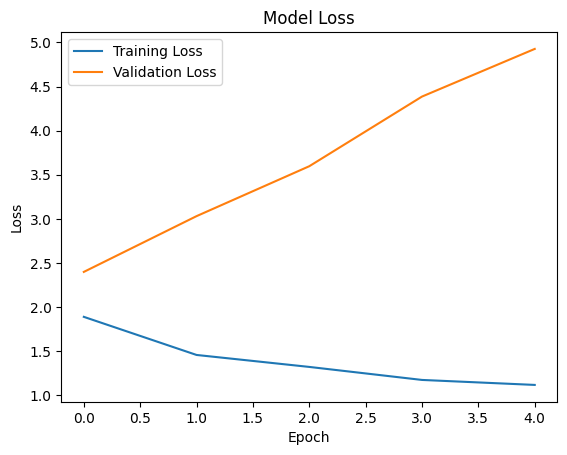

In [33]:
# Note: There will be a high memory requirement for the training steps below.
# You should work on a GPU/TPU based runtime. See 'Change Runtime' in Colab
# Training time for each epoch could be ~30 mins
# To save and re-load your model later, see the reference below:
# https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb

# YOUR CODE HERE
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPool2D, GlobalMaxPool2D
from tensorflow.keras.layers import TimeDistributed, GRU, Dense, Dropout, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam


# --- Training ---
batch_size = 32
epochs = 5
learning_rate = 0.001

model = create_cnn_gru_model(input_shape=train_data.shape[1:], num_classes=len(np.unique(train_labels)))
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(learning_rate=learning_rate), metrics=['accuracy'])
history = model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(test_data, test_labels))

# --- Plotting Loss ---
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Use pre-trained model for feature extraction (3 points)

To create a deep learning network for video classification:

* Convert videos to sequences of feature vectors using a pretrained convolutional neural network, such as VGG16, to extract features from each frame.

* Train an LSTM network on the sequences to predict the video labels.

* Assemble a network that classifies videos directly by combining layers from both networks.

Hint: [VGG-16 CNN and LSTM](https://riptutorial.com/keras/example/29812/vgg-16-cnn-and-lstm-for-video-classification)

#### Load and fine-tune the pre-trained model

In [46]:
# YOUR CODE HERE
import numpy as np
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
import os
import glob

# Load pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(112, 112, 3))
model = Model(inputs=base_model.input, outputs=base_model.get_layer('block5_pool').output)

img_height, img_width = 112, 112
seq_len = 10

def extract_features_from_folder(folder_path):
    """
    Extracts features from all video files in a folder.

    Args:
        folder_path: Path to the folder containing the video files.

    Returns:
        A dictionary where keys are video file names and values are NumPy arrays
        of shape (seq_len, feature_dim) representing the extracted features.
    """
    all_features = {}
    for dir in os.listdir(folder_path):
       # print(filename)
        for filename in os.listdir(os.path.join(folder_path, dir)):
            if filename.endswith(".avi"):  # Assuming your videos are in .avi format
                video_path = os.path.join(os.path.join(folder_path, dir), filename)
                features = extract_features(video_path)
                all_features[filename] = features
    return all_features

def extract_features(video_path):
    """
    Extracts features from a single video file.

    Args:
        video_path: Path to the video file.

    Returns:
        A NumPy array of shape (seq_len, feature_dim) representing the extracted features.
    """
    frames = []
    cap = cv2.VideoCapture(video_path)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_indices = np.linspace(0, frame_count - 1, seq_len, dtype=int)

    # Pad or truncate frames to ensure consistent length
    if frame_count < seq_len:
        # If the video has fewer frames than seq_len, duplicate the last frame
        last_frame = None
        for i in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if ret:
                frame = cv2.resize(frame, (img_height, img_width))
                frame = np.expand_dims(frame, axis=0)
                features = model.predict(frame, verbose=0)
                frames.append(features.flatten())
                last_frame = features.flatten()  # Store the last frame
            else:
                # If reading a frame fails, append the last valid frame
                if last_frame is not None:
                    frames.append(last_frame)
                else:
                    # Handle the case where no valid frames were read
                    # You might want to raise an error or return an empty array
                    raise ValueError(f"Could not read frames from video: {video_path}")

        # Pad the frames list if necessary
        while len(frames) < seq_len:
            frames.append(last_frame)
    else:
        # If the video has more frames than seq_len, proceed as before
        for i in frame_indices:
            cap.set(cv2.CAP_PROP_POS_FRAMES, i)
            ret, frame = cap.read()
            if ret:
                frame = cv2.resize(frame, (img_height, img_width))
                frame = np.expand_dims(frame, axis=0)  # Expand dimensions for prediction
                features = model.predict(frame, verbose=0)
                frames.append(features.flatten())

    # Ensure frames is a NumPy array and reshape if needed
    frames = np.array(frames)
    if frames.ndim == 1:  # Check if it's a 1D array
        frames = frames.reshape(1, -1)  # Reshape to 2D if necessary

    return frames  # Return the extracted features

# Example usage:
folder_path = '/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/train/'
all_video_features = extract_features_from_folder(folder_path)
#print(all_video_features)

In [48]:
# for filename, feature_seq in all_video_features.items():
#     print(f"Filename: {filename}, Feature Sequence Shape: {feature_seq}")
#     break

Filename: person01_walking_d1_uncomp.avi, Feature Sequence Shape: [[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        3.0581367 0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.8853833 0.       ]
 [0.        0.        0.        ... 0.        2.4578109 0.       ]
 [0.        0.        0.        ... 0.        1.2620418 0.       ]]


In [51]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os
import glob

# ... (Previous code for feature extraction) ...

def train_lstm_model(all_video_features, data_dir):
    """
    Trains an LSTM model on the extracted feature sequences.

    Args:
        all_video_features: A dictionary where keys are video file names and
                           values are NumPy arrays of shape (seq_len, feature_dim)
                           representing the extracted features.
        data_dir: The base directory where your training data is located
                  (e.g., '/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/train/').

    Returns:
        A trained Keras LSTM model.
    """
    # 1. Prepare data for LSTM
    features = []
    labels = []

    # Get the action class names from the subdirectories
    action_classes = os.listdir(data_dir)
    #print(action_classes)
    class_map = {label.lower(): i for i, label in enumerate(action_classes)}
    #print(class_map)
    #print(all_video_features)
    for filename, feature_seq in all_video_features.items():
        # Pad or truncate feature sequences to a fixed length
        if feature_seq.shape[0] < seq_len:  # If shorter than seq_len
            padding = np.zeros((seq_len - feature_seq.shape[0], feature_seq.shape[1]))
            feature_seq = np.concatenate([feature_seq, padding])
        elif feature_seq.shape[0] > seq_len:  # If longer than seq_len
            feature_seq = feature_seq[:seq_len]

        features.append(feature_seq)

        # Extract the action class from the filename (assumes a specific naming convention)
        #print(filename)
        action_class = filename.split('_')[1]
        labels.append(class_map[action_class.lower()])
        #print(11)
    ##print(1)
    #print(labels)
    features = np.array(features)  # Now features should have consistent shape
    labels = to_categorical(labels) # One-hot encode labels

    # 2. Split data into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size=0.2, random_state=42)
    print(features.shape)
    # 3. Create and compile the LSTM model
    model = Sequential()
    model.add(LSTM(256, input_shape=(features.shape[1], features.shape[2])))
    model.add(Dense(len(action_classes), activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # 4. Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

    return model

# Example usage:
# Assuming all_video_features is the dictionary from the previous feature extraction step
data_dir = '/content/drive/MyDrive/ISC/MiniProject/M6-Mp3/Actions/train/'  # Correct path to your training data
lstm_model = train_lstm_model(all_video_features, data_dir)

(479, 10, 4608)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.3592 - loss: 1.5173 - val_accuracy: 0.4375 - val_loss: 1.1618
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7280 - loss: 0.7487 - val_accuracy: 0.4896 - val_loss: 0.9468
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.8204 - loss: 0.5563 - val_accuracy: 0.4688 - val_loss: 0.9905
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9342 - loss: 0.4054 - val_accuracy: 0.5417 - val_loss: 0.9501
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9586 - loss: 0.3139 - val_accuracy: 0.5208 - val_loss: 0.9213
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9614 - loss: 0.2472 - val_accuracy: 0.5208 - val_loss: 0.9223
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9915 - loss: 0.1908 - val_accuracy: 0.5417 - val_loss: 0.9929
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9923 - loss: 0.1649 - val_accuracy: 0.5417 - v

In [56]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=42)

# Extract features from the training and validation data using the pre-trained model
X_train_features = [model.predict(np.expand_dims(frame, axis=0), verbose=0).flatten() for video in X_train for frame in video]
X_val_features = [model.predict(np.expand_dims(frame, axis=0), verbose=0).flatten() for video in X_val for frame in video]

# Reshape the extracted features to match the expected LSTM input shape
X_train_features = np.reshape(X_train_features, (X_train.shape[0], seq_len, -1))  # Reshape to (num_videos, seq_len, num_features)
X_val_features = np.reshape(X_val_features, (X_val.shape[0], seq_len, -1))

# Create the combined model
input_tensor = Input(shape=X_train_features.shape[1:])  # Use the shape of extracted features
lstm_layer = LSTM(256)(input_tensor)
output_layer = Dense(len(os.listdir(data_dir)), activation='softmax')(lstm_layer)
combined_model = Model(inputs=input_tensor, outputs=output_layer)

# Compile and train the combined model
combined_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Convert y_train and y_val to one-hot encoded labels
from tensorflow.keras.utils import to_categorical
y_train_onehot = to_categorical(y_train)  # Convert y_train to one-hot
y_val_onehot = to_categorical(y_val)  # Convert y_val to one-hot

# Now fit the model with one-hot encoded labels
combined_model.fit(X_train_features, y_train_onehot, epochs=10, batch_size=32, validation_data=(X_val_features, y_val_onehot), verbose=0)

#### Setup the parameters and train the model with epochs, batch wise

* Use train data to fit the model and test data for validation
* Configure batch size and epochs
* Plot the loss of train and test data

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.9957 - loss: 0.0498 - val_accuracy: 0.6458 - val_loss: 0.7757
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9967 - loss: 0.0408 - val_accuracy: 0.6667 - val_loss: 0.7700
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9974 - loss: 0.0385 - val_accuracy: 0.6667 - val_loss: 0.7578
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9947 - loss: 0.0397 - val_accuracy: 0.6562 - val_loss: 0.7725
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9994 - loss: 0.0313 - val_accuracy: 0.6458 - val_loss: 0.7944
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9923 - loss: 0.0356 - val_accuracy: 0.6458 - val_loss: 0.7940
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0329 - val_accuracy: 0.6458 - val_loss: 0.7963
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 1.0000 - loss: 0.0271 - val_accuracy: 0.6458 - v

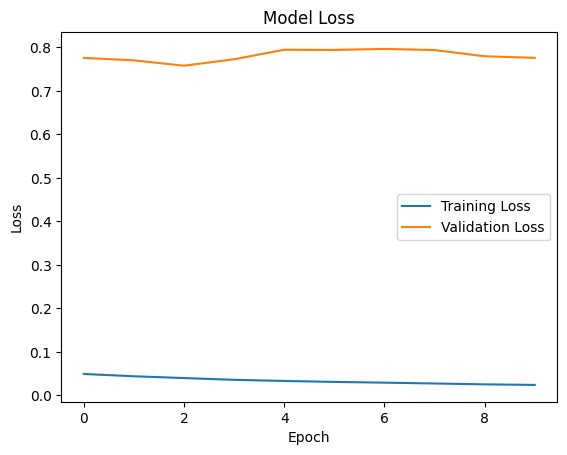

In [58]:
# YOUR CODE HERE
# 3. Train the model
batch_size = 32
epochs = 10
history = combined_model.fit(
    X_train_features,
    y_train_onehot,  # Use one-hot encoded labels
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val_features, y_val_onehot),  # Use one-hot encoded labels
)

# 4. Plot the loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Report Analysis

* Discuss on FPS, Number of frames and duration of each video
* Analyze the impact of the LSTM, GRU and TimeDistributed layers
* Discuss about the model convergence using pre-trained and ConvNet
* *Additional Reading*: Read and discuss about the use of Conv3D in video classification